# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
# These libraries may be useful to you
#You need to restart the Kernel after installation.
#!pip install pyLDAvis==3.4.1 --user
#!pip install spacy
#!pip install en_core_web_sm-3.1.0-py3-none-any.whl
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
#!python3 -m spacy download en_core_web_sm
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


In [2]:

# You also need a Python version => 3.9.0
import nltk
nltk.download('brown')
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = spacy.load("en_core_web_sm")
#nlp = en_core_web_sm.load()

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [3]:
# add any additional libaries you need here

from nltk.tokenize import word_tokenize

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

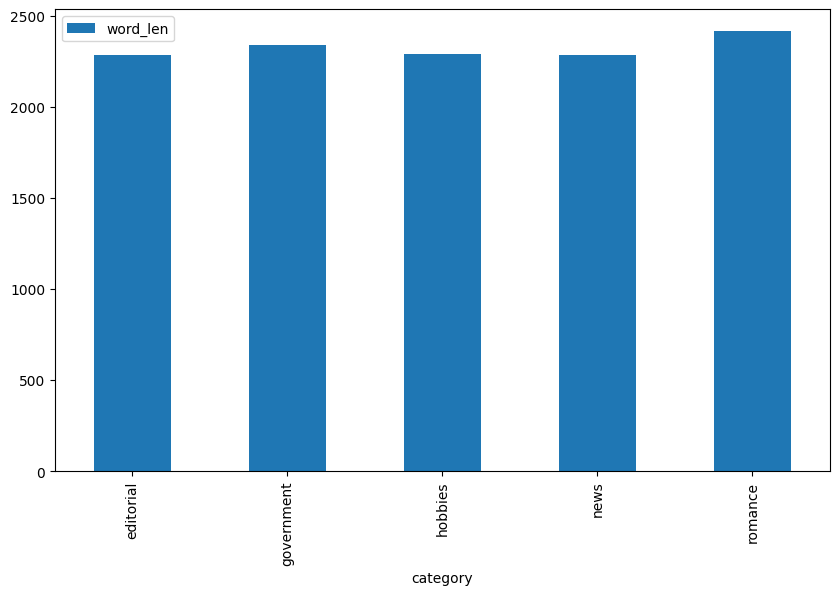

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape
pd.DataFrame(count_text_vectors.todense())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
162,0,2,0,0,0,0,0,0,1,2,...,0,0,0,3,0,0,0,0,0,0
163,0,0,4,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164,0,8,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape
pd.DataFrame(tfidf_text_vectors.todense())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,...,4931,4932,4933,4934,4935,4936,4937,4938,4939,4940
0,0.000000,0.046852,0.000000,0.000000,0.000000,0.000000,0.000000,0.023450,0.000000,0.019456,...,0.0,0.0,0.000000,0.016895,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.040107,0.000000,0.000000,0.000000,0.015896,0.000000,0.020074,0.000000,0.000000,...,0.0,0.0,0.000000,0.043389,0.000000,0.0,0.0,0.0,0.062348,0.0
2,0.000000,0.000000,0.000000,0.041794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.034956,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.016735,0.000000,0.000000,0.000000,0.039797,0.000000,0.000000,0.000000,0.020849,...,0.0,0.0,0.036429,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.014687,0.000000,0.018843,0.019635,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011308,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
162,0.000000,0.027690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018709,0.034496,...,0.0,0.0,0.000000,0.044933,0.000000,0.0,0.0,0.0,0.000000,0.0
163,0.000000,0.000000,0.037145,0.012368,0.000000,0.000000,0.022478,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
164,0.000000,0.083169,0.010015,0.013338,0.000000,0.012361,0.024242,0.000000,0.000000,0.012951,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: The matrices count_text_vectors and tfidf_text_vectors contain processed text data from the Brown corpus, transformed using CountVectorizer() and TfidfVectorizer() functions, respectively. count_text_vectors represents token frequencies, while tfidf_text_vectors represents TF-IDF scores. Both matrices exclude stop words and allow analysis of unique words (4941 columns) and their respective frequencies or scores across documents/texts (166 rows).

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [13]:
# Your code here

# Create a DataFrame to hold the text data
# Tally Brown categories for each NMF topic
df_nfm = df
df_nfm['Topic']= [W_text_matrix[i].tolist().index(W_text_matrix[i].max()) for i in range(len(df_nfm))]
topics = {0 : "Topic 0",
            1 : "Topic 1",
            2 : "Topic 2",
            3 : "Topic 3",
            4 : "Topic 4"}
df_nfm["Topic"] = df_nfm["Topic"].map(topics)
# count how many documents in each of the Brown categories are in each topic created by the NMF
df_nfm.groupby('Topic')['category'].value_counts()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic    category  
Topic 0  editorial     20
         news           8
         government     4
Topic 1  romance       29
         hobbies        8
         editorial      4
Topic 2  government    26
         hobbies       26
         news          11
         editorial      2
Topic 3  news          17
         hobbies        1
Topic 4  news           8
         editorial      1
         hobbies        1
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Topics Counts by Categories'}, xlabel='Topics', ylabel='Counts'>

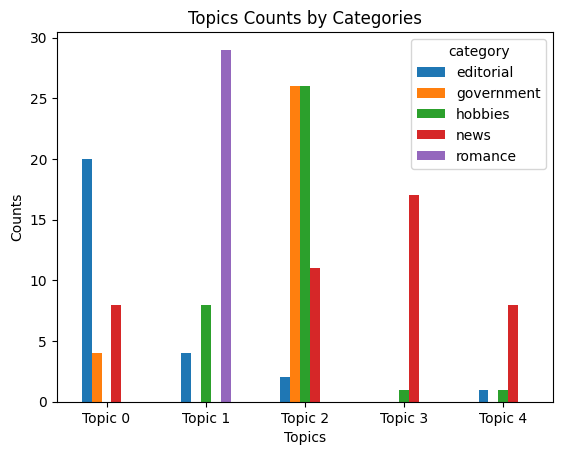

In [14]:
df_nfm.groupby(['Topic','category']).size().unstack().plot(kind='bar', ylabel='Counts', xlabel='Topics', title='Topics Counts by Categories', rot=0)


Q: How does your five-topic NMF model compare to the original Brown categories?

A: The Topic 0 is mainly editorial, considering the most counts for the category. Topic 1 is Romance, Topic 2 is a split between Government and Hobbies. Topic 3 and 4 are both news.

Although a definitive conclusion requires further analysis on our part, the initial visual comparison suggests that NMF model captures at least some aspects of the Brown categories. Investigating the underlying data would provide a more comprehensive understanding of the model's representativeness.



## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [15]:
# Your code here
svd_text_model = TruncatedSVD(n_components = 5, random_state=314)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# append the clustered topics to the dataframe using the highest probability in W_text_matrix
df_svd = df
df_svd['Topic']= [W_svd_text_matrix[i].tolist().index(W_svd_text_matrix[i].max()) for i in range(len(df_svd))]
topics = {0 : "Topic 0",
            1 : "Topic 1",
            2 : "Topic 2",
            3 : "Topic 3",
            4 : "Topic 4"}
df_svd["Topic"] = df_svd["Topic"].map(topics)
# count how many documents in each of the Brown categories are in each topic created by the NMF
df_svd.groupby('Topic')['category'].value_counts()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic    category  
Topic 0  hobbies       36
         news          34
         government    30
         editorial     27
         romance       21
Topic 1  romance        8
Topic 3  news           3
Topic 4  news           7
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Topics Counts by Categories'}, xlabel='Topics', ylabel='Counts'>

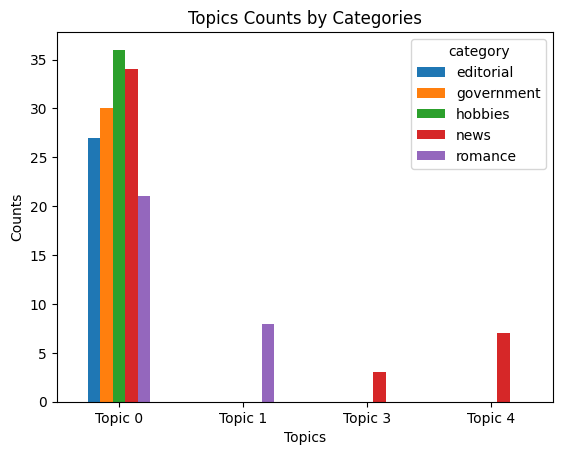

In [16]:
df_svd.groupby(['Topic','category']).size().unstack().plot(kind='bar', ylabel='Counts', xlabel='Topics', title='Topics Counts by Categories', rot=0)


Q: How does your five-topic LSA model compare to the original Brown categories?

A: Based on the groupby value counts, the LSA model appears to struggle with clearly differentiating the Brown categories within some topics.

Topic 0: Lacks distinct category separation, suggesting documents might be spread across various categories instead of forming a cohesive group.
Topic 1, 3, and 4: Each primarily associates with only one category, but these categories also appear in other topics, leading to ambiguity. Interestingly, topics 3 and 4 seem to merge into one category, indicating potential redundancy.
Missing topic 2: The complete absence of this topic suggests LSA might not fully represent the entire range of categories present in the data.

In [17]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output?

A: The LSA Model Topics are hard to decipher. Words like "said", "mr", "mrs" are seen in multiple topics. Deciphering the LSA model's topics is tricky due to common words like "mr" and "mrs" showing up in various topics. While Topic04 relates to hobbies, others lack clear connections. Including many everyday words like "said" may blur results. Still, Topic04 stands out for its clear link to sports. These findings stress the need for better word filtering and deeper topic analysis in LSA modeling.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [18]:
# Fit your LDA model here
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_
# Your code here

# append the clustered topics to the dataframe using the highest probability in W_text_matrix
df_lda = df
df_lda['Topic']= [W_lda_text_matrix[i].tolist().index(W_lda_text_matrix[i].max()) for i in range(len(df_lda))]
topics = {0 : "Topic 0",
            1 : "Topic 1",
            2 : "Topic 2",
            3 : "Topic 3",
            4 : "Topic 4"}
df_lda["Topic"] = df_lda["Topic"].map(topics)
# count how many documents in each of the Brown categories are in each topic created by the NMF
df_lda.groupby('Topic')['category'].value_counts()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic    category  
Topic 0  romance       28
         hobbies       11
         news           4
         editorial      3
         government     1
Topic 1  government    12
         hobbies        9
         news           3
         editorial      1
Topic 2  news          32
         editorial     21
         government     3
         hobbies        2
         romance        1
Topic 3  hobbies        8
         government     4
         news           3
         editorial      2
Topic 4  government    10
         hobbies        6
         news           2
Name: count, dtype: int64

In [19]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: title={'center': 'Topics Counts by Categories'}, xlabel='Topics', ylabel='Counts'>

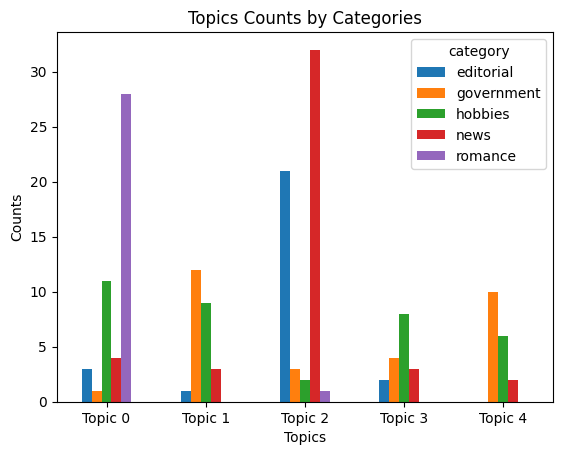

In [20]:
df_lda.groupby(['Topic','category']).size().unstack().plot(kind='bar', ylabel='Counts', xlabel='Topics', title='Topics Counts by Categories', rot=0)

Q: What inference do you draw from the displayed topics for your LDA model?

A: The LDA model highlights that topics like "news" are distinguishable by keywords such as "president," "city," or "state" in Topic02. Similarly, Topic01's keywords may suggest topics related to "government." However, other topics lack clear connections to categories like "Romance" and "Editorial." The keywords in these topics do not sufficiently match the themes of these categories.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: Comparing the five-topic LDA model with the original Brown categories, the LDA model exhibits improved performance over the previous LSA model. The categorization within each topic is more distinct, with clearer distinctions observed. For instance, Topic01 and Topic04 show similar counts for "government" and "hobbies," while Topic02 primarily consists of "news" and "editorial" documents. Topic 0 encompasses a mix of editorial, government, news, and romance, while Topic 1 solely focuses on romance. Topic 3 is entirely composed of news, and Topic 4 predominantly comprises news as well.

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: PC3 (topic02) holds 32% of tokens, with "news" and "editorial" documents, hinting at overlap. PC4 (topic03) has only 12.4% tokens, featuring "feed" and "college," supporting "hobbies." Interactive exploration reveals unique tokens per topic. While topics are distinct, 2 and 4 are similar, and 3 is broader.

In [21]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
